
# Can a computer learn if we're going to detect gravitational waves?

This episode of "time to get your hands dirty" is about something I studied carefully in the past: gravitational-wave selection effects.

All experiments have selection effects. Some sources are easier to detect than others which distorts the population of sources we observe (this is crucial in astronomy! Surveys are typically flux limited). In order to decided if a feature in the observed population of objects is telling us something new about reality, we need to understand and model our selection effects (for instance: it would be wrong to say that all stars are close by just because we can't observe those that are very far!). In observational astronomy, this is known as Malmquist bias and was first formulated in 1922.

The goal here is to machine-learn the LIGO detectability: can we predict if a gravitational-wave source will be detected?

[This dataset](https://github.com/dgerosa/pdetclassifier/releases/download/v0.2/sample_2e7_design_precessing_higherordermodes_3detectors.h5) contains simulated gravitational-wave signals from merging black holes (careful the file size is >1 GB). If you've never seen them, the .h5 format is a highly optimized storage strategy for large datasets. It's amazing. In python, you can read it with h5py.

In particular, each source has the following features:

- mtot: the total mass of the binary
- q: the mass ratio
- chi1x, chi1y, chi1z, chi2x, chi2y, chi2z: the components of the black-hole spins in a suitable reference frame.
- ra, dec: the location of the source in the sky
- iota: the inclination of the orbital plane'
- psi: the polarization angle (gravitational waves have two polarization states much like light)
- z: the redshift

The detectability is defined using the snr (signal-to-noise ratio) computed with a state-of-the-art model of the LIGO/Virgo detector network. Some (many?) of you will have studied this in Sesana's gravitational-wave course; see [here](https://arxiv.org/abs/1908.11170) for a nice write-up. All you need to know now is that we threshold the snr values and assume that LIGO will (not) see a source if snr>12 (snr<12). The resulting 0-1 labels are reported in the det attribute in the dataset.

Today's task is to train a classifier (you decide which one!) and separate sources that are detectables from those that aren't.

Be creative! This is a challenge! Let's see who gets the higher completeness and/or the smaller contamination (on a validation set, of course! Careful with overfitting here!).

Tips:

- You can downsample the data for debugging purposes
- You can also use only some of the features.

In [1]:
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from IPython.display import display, Markdown

from sklearn.model_selection import train_test_split, KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix

from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [2]:
data = h5py.File('sample_2e7_design_precessing_higherordermodes_3detectors.h5')
data.keys()

<KeysViewHDF5 ['chi1x', 'chi1y', 'chi1z', 'chi2x', 'chi2y', 'chi2z', 'dec', 'det', 'iota', 'mtot', 'psi', 'q', 'ra', 'snr', 'z']>

In [3]:
# Downsampling the data
N = 100000

In [4]:
X=[]

for label in ['chi1x', 'chi1y', 'chi1z', 'chi2x', 'chi2y', 'chi2z', 'dec', 'iota', 'mtot', 'psi', 'q', 'ra','z']:
    
    X.append(data[label][:N])
    
X = np.array(X).T
y = np.array(data['det'][:N])     # 0 = snr < 12, 1 = snr >12

In [5]:
X.shape

(100000, 13)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=336)


## Basic decision tree

First, we can start with a basic decision tree. We can use cross-validation to decide the best depth.

In [7]:
n_splits = 5

depths_range = np.arange(1, 21, dtype = int)

accuracy_cv_array = np.empty(len(depths_range))
precision_cv_array = np.empty(len(depths_range))
completeness_cv_array = np.empty(len(depths_range))

kf = KFold(n_splits=n_splits, shuffle=True, random_state=336)

for i, depth in tqdm(enumerate(depths_range), total = len(depths_range)):
    
    dtc = DecisionTreeClassifier(max_depth = depth, criterion = 'entropy', random_state = 336)
    
    accuracy = []
    precision = []
    completeness = []
    
    for train_index, test_index in kf.split(X_train):
        X_train_cv, X_test_cv = X_train[train_index], X_train[test_index]
        y_train_cv, y_test_cv = y_train[train_index], y_train[test_index]

        # Leaving X_test and y_test for the final evaluation
        
        dtc.fit(X_train_cv, y_train_cv)
        y_pred_test_cv = dtc.predict(X_test_cv)
        
        accuracy.append(accuracy_score(y_test_cv, y_pred_test_cv))
        precision.append(precision_score(y_test_cv, y_pred_test_cv))
        completeness.append(recall_score(y_test_cv, y_pred_test_cv))

    accuracy_cv_array[i] = np.mean(accuracy)
    precision_cv_array[i] = np.mean(precision)
    completeness_cv_array[i] = np.mean(completeness)

  0%|          | 0/20 [00:00<?, ?it/s]

In [8]:
accuracy_cv_array

array([0.92288571, 0.92781429, 0.93218571, 0.9429    , 0.94497143,
       0.9485    , 0.95027143, 0.95701429, 0.95665714, 0.95651429,
       0.95582857, 0.95528571, 0.95428571, 0.95342857, 0.9531    ,
       0.95224286, 0.95162857, 0.95178571, 0.95117143, 0.95105714])

Note: since this is an unbalanced dataset, getting a high accuracy doesn't automatically mean that we used the best classifier; therefore, we can also try using contamination* and completeness as the score for the CV.

_*Computed as 1-precision, so that we can maximize all the scores to find the best hyperparameters._

In [9]:
precision_cv_array

array([0.67871876, 0.91711058, 0.7538054 , 0.78234661, 0.86056539,
       0.80799546, 0.86252829, 0.86049969, 0.84792979, 0.85438894,
       0.84796288, 0.85068202, 0.8441197 , 0.8413222 , 0.84125028,
       0.83583236, 0.83394462, 0.83395785, 0.83075849, 0.83032713])

In [10]:
completeness_cv_array

array([0.87657859, 0.5456406 , 0.81183532, 0.8332702 , 0.73916987,
       0.84026065, 0.77786292, 0.8356673 , 0.84999166, 0.839558  ,
       0.84286386, 0.83436587, 0.83509389, 0.83169829, 0.82899742,
       0.82954593, 0.82695165, 0.82829003, 0.82781216, 0.82740958])

In [11]:
print('Depths considered:')
print(depths_range)

scoring_metrics = ['Accuracy', 'Contamination', 'Completeness']
cv_arrays = [accuracy_cv_array, precision_cv_array, completeness_cv_array]

best_depths_dtc = np.empty(3)

for i in range(3):

    best_index = np.argmax(cv_arrays[i])   
    best_depths_dtc[i] = depths_range[best_index]
    print('\nScoring metric: ' + str(scoring_metrics[i]))
    print(' Best depth: %i' % best_depths_dtc[i]) 

Depths considered:
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]

Scoring metric: Accuracy
 Best depth: 8

Scoring metric: Contamination
 Best depth: 2

Scoring metric: Completeness
 Best depth: 1


With this values, we can see how the Decision Tree performs:

In [12]:
accuracies_train_dtc = np.empty(3)
contaminations_train_dtc = np.empty(3)
completenesses_train_dtc = np.empty(3)
tp_train_dtc = np.empty(3)
fp_train_dtc = np.empty(3)
fn_train_dtc = np.empty(3)
tn_train_dtc = np.empty(3)

accuracies_test_dtc = np.empty(3)
contaminations_test_dtc = np.empty(3)
completenesses_test_dtc = np.empty(3)
tp_test_dtc = np.empty(3)
fp_test_dtc = np.empty(3)
fn_test_dtc = np.empty(3)
tn_test_dtc = np.empty(3)

y_prob_dtc = []

for i in range(3):

    dtc = DecisionTreeClassifier(max_depth = int(best_depths_dtc[i]), random_state = 336)
    dtc.fit(X_train, y_train)
    y_train_pred = dtc.predict(X_train)
    y_test_pred = dtc.predict(X_test)
    y_prob = dtc.predict_proba(X_test)[:, 1] 

    accuracies_train_dtc[i] = accuracy_score(y_train, y_train_pred)
    contaminations_train_dtc[i] = 1 - precision_score(y_train, y_train_pred)
    completenesses_train_dtc[i] = recall_score(y_train, y_train_pred)
    conf_matrix_train = confusion_matrix(y_train, y_train_pred)
    tn_train_dtc[i], fp_train_dtc[i], fn_train_dtc[i], tp_train_dtc[i] = conf_matrix_train.ravel()
    
    accuracies_test_dtc[i] = accuracy_score(y_test, y_test_pred)
    contaminations_test_dtc[i] = 1 - precision_score(y_test, y_test_pred)
    completenesses_test_dtc[i] = recall_score(y_test, y_test_pred)
    conf_matrix_test = confusion_matrix(y_test, y_test_pred)
    tn_test_dtc[i], fp_test_dtc[i], fn_test_dtc[i], tp_test_dtc[i] = conf_matrix_test.ravel()

    y_prob_dtc.append(y_prob)

In [13]:
train_table_dtc = pd.DataFrame({
    'Scoring metric for CV': scoring_metrics,
    'Max_depth': best_depths_dtc,
    'Accuracy': accuracies_train_dtc,
    'Contamination': contaminations_train_dtc,
    'Completeness': completenesses_train_dtc,
    'True positives': tp_train_dtc,
    'False positives': fp_train_dtc,
    'False negatives': fn_train_dtc,
    'True negatives': tn_train_dtc
})

train_table_dtc[['Accuracy', 'Contamination', 'Completeness']] = train_table_dtc[['Accuracy', 'Contamination', 'Completeness']].round(3)
train_table_dtc[['Max_depth', 'True positives', 'False positives', 'False negatives', 'True negatives']] = train_table_dtc[['Max_depth', 'True positives', 'False positives', 'False negatives', 'True negatives']].astype(int)



test_table_dtc = pd.DataFrame({
    'Scoring metric for CV': scoring_metrics,
    'Max_depth': best_depths_dtc,
    'Accuracy': accuracies_test_dtc,
    'Contamination': contaminations_test_dtc,
    'Completeness': completenesses_test_dtc,
    'True positives': tp_test_dtc,
    'False positives': fp_test_dtc,
    'False negatives': fn_test_dtc,
    'True negatives': tn_test_dtc
})

test_table_dtc[['Accuracy', 'Contamination', 'Completeness']] = test_table_dtc[['Accuracy', 'Contamination', 'Completeness']].round(3)
test_table_dtc[['Max_depth', 'True positives', 'False positives', 'False negatives', 'True negatives']] = test_table_dtc[['Max_depth', 'True positives', 'False positives', 'False negatives', 'True negatives']].astype(int)


In [14]:
display(Markdown("### Results of simple decision tree classification on train dataset:"))
display(train_table_dtc)

display(Markdown("### Results of simple decision tree classification on test dataset:"))
display(test_table_dtc)

### Results of simple decision tree classification on train dataset:

,Scoring metric for CV,Max_depth,Accuracy,Contamination,Completeness,True positives,False positives,False negatives,True negatives
0,Accuracy,8,0.966,0.119,0.883,8854,1194,1168,58784
1,Contamination,2,0.936,0.230,0.788,7901,2363,2121,57615
2,Completeness,1,0.936,0.230,0.788,7901,2363,2121,57615


### Results of simple decision tree classification on test dataset:

,Scoring metric for CV,Max_depth,Accuracy,Contamination,Completeness,True positives,False positives,False negatives,True negatives
0,Accuracy,8,0.957,0.146,0.853,3719,635,641,25005
1,Contamination,2,0.935,0.232,0.788,3435,1036,925,24604
2,Completeness,1,0.935,0.232,0.788,3435,1036,925,24604


For this particular split of train and test data, max_depth = 1 and max_depth = 2 yield the same results in terms of cross-validation with contamination and completeness as scoring metrics. The best classifier out of these is clearly the one with the best accuracy, so the decision tree with max_depth = 8.

To improve the performance, we can try bagging and a random forest.


## Bagged decision tree

We'll cross-validate on the depth and the number of trees.

In [15]:
n_splits = 5

n_range = [5, 10, 15]
depths_range = np.arange(1, 11, dtype = int)

accuracy_cv_matrix = np.empty((len(n_range), len(depths_range)))
precision_cv_matrix = np.empty((len(n_range), len(depths_range)))
completeness_cv_matrix = np.empty((len(n_range), len(depths_range)))

kf = KFold(n_splits=n_splits, shuffle=True, random_state=336)

for i, ntrees in tqdm(enumerate(n_range), total = len(n_range)):

    for j, depth in tqdm(enumerate(depths_range), total = len(depths_range)):
    
        dtc = DecisionTreeClassifier(max_depth = depth, criterion = 'entropy', random_state = 336)
        bag_dtc = BaggingClassifier(estimator = dtc,  n_estimators = ntrees, random_state=336, n_jobs=-1)
        
        accuracy = []
        precision = []
        completeness = []
        
        for train_index, test_index in kf.split(X_train):
            X_train_cv, X_test_cv = X_train[train_index], X_train[test_index]
            y_train_cv, y_test_cv = y_train[train_index], y_train[test_index]
            
            bag_dtc.fit(X_train_cv, y_train_cv)
            y_pred_test_cv = bag_dtc.predict(X_test_cv)
            
            accuracy.append(accuracy_score(y_test_cv, y_pred_test_cv))
            precision.append(precision_score(y_test_cv, y_pred_test_cv, zero_division=0))
            completeness.append(recall_score(y_test_cv, y_pred_test_cv))
    
        accuracy_cv_matrix[i, j] = np.mean(accuracy)
        precision_cv_matrix[i, j] = np.mean(precision)
        completeness_cv_matrix[i, j] = np.mean(completeness)


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [16]:
accuracy_cv_matrix

array([[0.92375714, 0.93031429, 0.93461429, 0.94435714, 0.94817143,
        0.95298571, 0.95944286, 0.96104286, 0.96191429, 0.96208571],
       [0.92328571, 0.93332857, 0.93537143, 0.94412857, 0.94964286,
        0.95255714, 0.96007143, 0.9616    , 0.9632    , 0.96361429],
       [0.92334286, 0.93277143, 0.936     , 0.94494286, 0.94985714,
        0.9533    , 0.96091429, 0.96212857, 0.9635    , 0.964     ]])

In [17]:
precision_cv_matrix

array([[0.68272787, 0.85566343, 0.73349494, 0.79381455, 0.83000936,
        0.84922077, 0.87497661, 0.88251617, 0.88184612, 0.88242111],
       [0.68056292, 0.88852456, 0.73769826, 0.79183526, 0.83310452,
        0.84338933, 0.87861728, 0.88640935, 0.88702715, 0.88736915],
       [0.68081406, 0.8916935 , 0.7637933 , 0.79575397, 0.83355968,
        0.85080394, 0.8856288 , 0.88795157, 0.8883553 , 0.88793745]])

In [18]:
completeness_cv_matrix

array([[0.87419794, 0.64547952, 0.8545796 , 0.82688731, 0.80463658,
        0.81682339, 0.83652495, 0.83989092, 0.84767694, 0.84829108],
       [0.87535505, 0.61155753, 0.85183569, 0.8278436 , 0.81125138,
        0.82144106, 0.83721522, 0.83954869, 0.85156759, 0.85437314],
       [0.87515854, 0.60418957, 0.81343538, 0.82826542, 0.81250576,
        0.81739769, 0.83509512, 0.84188983, 0.85226707, 0.85679936]])

In [19]:
print('Numbers of trees considered:')
print(n_range)

print('Depths considered:')
print(depths_range)

cv_matrices = [accuracy_cv_matrix, precision_cv_matrix, completeness_cv_matrix]

best_n_est_bag = np.empty(3)
best_depths_bag = np.empty(3)

for i in range(3):

    best_index_flat = np.argmax(cv_matrices[i]) 
    best_index_2d = np.unravel_index(best_index_flat, cv_matrices[i].shape)
    
    best_n_est_bag[i] = n_range[best_index_2d[0]]
    best_depths_bag[i] = depths_range[best_index_2d[1]]
    
    print('\nScoring metric: ' + str(scoring_metrics[i]))
    print(' Best number of trees: %i' % best_n_est_bag[i]) 
    print(' Best max_depth: %i' % best_depths_bag[i]) 

Numbers of trees considered:
[5, 10, 15]
Depths considered:
[ 1  2  3  4  5  6  7  8  9 10]

Scoring metric: Accuracy
 Best number of trees: 15
 Best max_depth: 10

Scoring metric: Contamination
 Best number of trees: 15
 Best max_depth: 2

Scoring metric: Completeness
 Best number of trees: 10
 Best max_depth: 1


In [20]:
accuracies_train_bag = np.empty(3)
contaminations_train_bag = np.empty(3)
completenesses_train_bag = np.empty(3)
tp_train_bag = np.empty(3)
fp_train_bag = np.empty(3)
fn_train_bag = np.empty(3)
tn_train_bag = np.empty(3)

accuracies_test_bag = np.empty(3)
contaminations_test_bag = np.empty(3)
completenesses_test_bag = np.empty(3)
tp_test_bag = np.empty(3)
fp_test_bag = np.empty(3)
fn_test_bag = np.empty(3)
tn_test_bag = np.empty(3)

y_prob_bag = []

for (i, ntrees), depth in tqdm(zip(enumerate(best_n_est_bag), best_depths_bag), total=len(best_n_est_bag)):

    dtc = DecisionTreeClassifier(max_depth = int(depth), criterion = 'entropy', random_state = 336)
    bag_dtc = BaggingClassifier(estimator = dtc,  n_estimators = int(ntrees), random_state=336, n_jobs=-1)
    bag_dtc.fit(X_train, y_train)
    y_train_pred = bag_dtc.predict(X_train)
    y_test_pred = bag_dtc.predict(X_test)
    y_prob = bag_dtc.predict_proba(X_test)[:, 1]

    accuracies_train_bag[i] = accuracy_score(y_train, y_train_pred)
    contaminations_train_bag[i] = 1 - precision_score(y_train, y_train_pred)
    completenesses_train_bag[i] = recall_score(y_train, y_train_pred)
    conf_matrix_train = confusion_matrix(y_train, y_train_pred)
    tn_train_bag[i], fp_train_bag[i], fn_train_bag[i], tp_train_bag[i] = conf_matrix_train.ravel()
    
    accuracies_test_bag[i] = accuracy_score(y_test, y_test_pred)
    contaminations_test_bag[i] = 1 - precision_score(y_test, y_test_pred)
    completenesses_test_bag[i] = recall_score(y_test, y_test_pred)
    conf_matrix_test = confusion_matrix(y_test, y_test_pred)
    tn_test_bag[i], fp_test_bag[i], fn_test_bag[i], tp_test_bag[i] = conf_matrix_test.ravel()

    y_prob_bag.append(y_prob)


  0%|          | 0/3 [00:00<?, ?it/s]

In [21]:
train_table_bag = pd.DataFrame({
    'Scoring metric for CV': scoring_metrics,
    'Number of trees': best_n_est_bag,
    'Max_depth': best_depths_bag,
    'Accuracy': accuracies_train_bag,
    'Contamination': contaminations_train_bag,
    'Completeness': completenesses_train_bag,
    'True positives': tp_train_bag,
    'False positives': fp_train_bag,
    'False negatives': fn_train_bag,
    'True negatives': tn_train_bag
})

train_table_bag[['Accuracy', 'Contamination', 'Completeness']] = train_table_bag[['Accuracy', 'Contamination', 'Completeness']].round(3)
train_table_bag[['Number of trees', 'Max_depth', 'True positives', 'False positives', 'False negatives', 'True negatives']] = train_table_bag[['Number of trees', 'Max_depth', 'True positives', 'False positives', 'False negatives', 'True negatives']].astype(int)



test_table_bag = pd.DataFrame({
    'Scoring metric for CV': scoring_metrics,
    'Number of trees': best_n_est_bag,
    'Max_depth': best_depths_bag,
    'Accuracy': accuracies_test_bag,
    'Contamination': contaminations_test_bag,
    'Completeness': completenesses_test_bag,
    'True positives': tp_test_bag,
    'False positives': fp_test_bag,
    'False negatives': fn_test_bag,
    'True negatives': tn_test_bag
})

test_table_bag[['Accuracy', 'Contamination', 'Completeness']] = test_table_bag[['Accuracy', 'Contamination', 'Completeness']].round(3)
test_table_bag[['Number of trees', 'Max_depth', 'True positives', 'False positives', 'False negatives', 'True negatives']] = test_table_bag[['Number of trees', 'Max_depth', 'True positives', 'False positives', 'False negatives', 'True negatives']].astype(int)


In [22]:
display(Markdown("### Results of bagged decision tree classification on train dataset:"))
display(train_table_bag)

display(Markdown("### Results of bagged decision tree classification on test dataset:"))
display(test_table_bag)

### Results of bagged decision tree classification on train dataset:

,Scoring metric for CV,Number of trees,Max_depth,Accuracy,Contamination,Completeness,True positives,False positives,False negatives,True negatives
0,Accuracy,15,10,0.976,0.078,0.906,9078,766,944,59212
1,Contamination,15,2,0.933,0.104,0.602,6038,700,3984,59278
2,Completeness,10,1,0.925,0.313,0.872,8738,3990,1284,55988


### Results of bagged decision tree classification on test dataset:

,Scoring metric for CV,Number of trees,Max_depth,Accuracy,Contamination,Completeness,True positives,False positives,False negatives,True negatives
0,Accuracy,15,10,0.962,0.117,0.852,3714,492,646,25148
1,Contamination,15,2,0.933,0.102,0.607,2646,301,1714,25339
2,Completeness,10,1,0.921,0.324,0.869,3789,1813,571,23827


The results of the bagged decision tree classifier are slightly better than the ones for the single decision tree.


## Random forest

We'll cross-validate on the same parameters as before.

In [23]:
n_splits = 5

n_range = [50, 100, 200]
depths_range = np.arange(8, 14, dtype = int)
# Note: I've chosen this range for the depths because I've tried various ranges and they all went into overfitting, so I 
# decreased the max_depth allowed and increased min_samples_split from 2 to 20 to avoid it; since the trees always wanted
# to go to the maximum possible depth, I've abandoned the first values to decrease computational costs.

accuracy_cv_matrix = np.empty((len(n_range), len(depths_range)))
precision_cv_matrix = np.empty((len(n_range), len(depths_range)))
completeness_cv_matrix = np.empty((len(n_range), len(depths_range)))

kf = KFold(n_splits=n_splits, shuffle=True, random_state=336)

for i, ntrees in tqdm(enumerate(n_range), total = len(n_range)):

    for j, depth in tqdm(enumerate(depths_range), total = len(depths_range)):
    
        rand_for = RandomForestClassifier(max_depth = depth, n_estimators = ntrees, min_samples_split = 20, criterion = 'entropy', random_state = 336, n_jobs = -1)
        
        accuracy = []
        precision = []
        completeness = []
        
        for train_index, test_index in kf.split(X_train):
            X_train_cv, X_test_cv = X_train[train_index], X_train[test_index]
            y_train_cv, y_test_cv = y_train[train_index], y_train[test_index]
            
            rand_for.fit(X_train_cv, y_train_cv)
            y_pred_test_cv = rand_for.predict(X_test_cv)
            
            accuracy.append(accuracy_score(y_test_cv, y_pred_test_cv))
            precision.append(precision_score(y_test_cv, y_pred_test_cv, zero_division=0))
            completeness.append(recall_score(y_test_cv, y_pred_test_cv))
    
        accuracy_cv_matrix[i, j] = np.mean(accuracy)
        precision_cv_matrix[i, j] = np.mean(precision)
        completeness_cv_matrix[i, j] = np.mean(completeness)


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [24]:
accuracy_cv_matrix

array([[0.95871429, 0.95978571, 0.96101429, 0.96181429, 0.96317143,
        0.96382857],
       [0.95894286, 0.96      , 0.9612    , 0.96227143, 0.96347143,
        0.96371429],
       [0.95921429, 0.96021429, 0.96102857, 0.96224286, 0.96348571,
        0.96387143]])

In [25]:
precision_cv_matrix

array([[0.89350313, 0.90049964, 0.89724531, 0.89486253, 0.901838  ,
        0.90201185],
       [0.89068323, 0.89356691, 0.89449967, 0.89756033, 0.90193162,
        0.9002779 ],
       [0.88886193, 0.89211263, 0.8935316 , 0.898593  , 0.90145566,
        0.90063753]])

In [26]:
completeness_cv_matrix

array([[0.80805759, 0.808849  , 0.82209953, 0.83115859, 0.83371785,
        0.83863859],
       [0.81318663, 0.81835885, 0.82674693, 0.83158506, 0.83591351,
        0.83974763],
       [0.8174889 , 0.82164038, 0.82646467, 0.83015075, 0.83662742,
        0.84055285]])

In [27]:
print('Numbers of estimators considered:')
print(n_range)

print('Depths considered:')
print(depths_range)

cv_matrices = [accuracy_cv_matrix, precision_cv_matrix, completeness_cv_matrix]

best_n_est_ran = np.empty(3)
best_depths_ran = np.empty(3)

for i in range(3):

    best_index_flat = np.argmax(cv_matrices[i]) 
    best_index_2d = np.unravel_index(best_index_flat, cv_matrices[i].shape)
    
    best_n_est_ran[i] = n_range[best_index_2d[0]]
    best_depths_ran[i] = depths_range[best_index_2d[1]]
    
    print('\nScoring metric: ' + str(scoring_metrics[i]))
    print(' Best number of estimators: %.2f' % best_n_est_ran[i]) 
    print(' Best max_depth: %i' % best_depths_ran[i]) 

Numbers of estimators considered:
[50, 100, 200]
Depths considered:
[ 8  9 10 11 12 13]

Scoring metric: Accuracy
 Best number of estimators: 200.00
 Best max_depth: 13

Scoring metric: Contamination
 Best number of estimators: 50.00
 Best max_depth: 13

Scoring metric: Completeness
 Best number of estimators: 200.00
 Best max_depth: 13


In [28]:
accuracies_train_ran = np.empty(3)
contaminations_train_ran = np.empty(3)
completenesses_train_ran = np.empty(3)
tp_train_ran = np.empty(3)
fp_train_ran = np.empty(3)
fn_train_ran = np.empty(3)
tn_train_ran = np.empty(3)

accuracies_test_ran = np.empty(3)
contaminations_test_ran = np.empty(3)
completenesses_test_ran = np.empty(3)
tp_test_ran = np.empty(3)
fp_test_ran = np.empty(3)
fn_test_ran = np.empty(3)
tn_test_ran = np.empty(3)

y_prob_ran = []

for (i, ntrees), depth in tqdm(zip(enumerate(best_n_est_ran), best_depths_ran), total=len(best_n_est_ran)):

    rand_for = RandomForestClassifier(max_depth = int(depth), n_estimators = int(ntrees), criterion = 'entropy', random_state = 336, n_jobs = -1)
    rand_for.fit(X_train, y_train)
    y_train_pred = rand_for.predict(X_train)
    y_test_pred = rand_for.predict(X_test)
    y_prob = rand_for.predict_proba(X_test)[:, 1]

    accuracies_train_ran[i] = accuracy_score(y_train, y_train_pred)
    contaminations_train_ran[i] = 1 - precision_score(y_train, y_train_pred)
    completenesses_train_ran[i] = recall_score(y_train, y_train_pred)
    conf_matrix_train = confusion_matrix(y_train, y_train_pred)
    tn_train_ran[i], fp_train_ran[i], fn_train_ran[i], tp_train_ran[i] = conf_matrix_train.ravel()
    
    accuracies_test_ran[i] = accuracy_score(y_test, y_test_pred)
    contaminations_test_ran[i] = 1 - precision_score(y_test, y_test_pred)
    completenesses_test_ran[i] = recall_score(y_test, y_test_pred)
    conf_matrix_test = confusion_matrix(y_test, y_test_pred)
    tn_test_ran[i], fp_test_ran[i], fn_test_ran[i], tp_test_ran[i] = conf_matrix_test.ravel()

    y_prob_ran.append(y_prob)

  0%|          | 0/3 [00:00<?, ?it/s]

In [29]:
train_table_ran = pd.DataFrame({
    'Scoring metric for CV': scoring_metrics,
    'Number of trees': best_n_est_ran,
    'Max_depth': best_depths_ran,
    'Accuracy': accuracies_train_ran,
    'Contamination': contaminations_train_ran,
    'Completeness': completenesses_train_ran,
    'True positives': tp_train_ran,
    'False positives': fp_train_ran,
    'False negatives': fn_train_ran,
    'True negatives': tn_train_ran
})

train_table_ran[['Accuracy', 'Contamination', 'Completeness']] = train_table_ran[['Accuracy', 'Contamination', 'Completeness']].round(3)
train_table_ran[['Number of trees', 'Max_depth', 'True positives', 'False positives', 'False negatives', 'True negatives']] = train_table_ran[['Number of trees', 'Max_depth', 'True positives', 'False positives', 'False negatives', 'True negatives']].astype(int)



test_table_ran = pd.DataFrame({
    'Scoring metric for CV': scoring_metrics,
    'Number of trees': best_n_est_ran,
    'Max_depth': best_depths_ran,
    'Accuracy': accuracies_test_ran,
    'Contamination': contaminations_test_ran,
    'Completeness': completenesses_test_ran,
    'True positives': tp_test_ran,
    'False positives': fp_test_ran,
    'False negatives': fn_test_ran,
    'True negatives': tn_test_ran
})

test_table_ran[['Accuracy', 'Contamination', 'Completeness']] = test_table_ran[['Accuracy', 'Contamination', 'Completeness']].round(3)
test_table_ran[['Number of trees', 'Max_depth', 'True positives', 'False positives', 'False negatives', 'True negatives']] = test_table_ran[['Number of trees', 'Max_depth', 'True positives', 'False positives', 'False negatives', 'True negatives']].astype(int)


In [30]:
display(Markdown("### Results of random forest classification on train dataset:"))
display(train_table_ran)

display(Markdown("### Results of random forest classification on test dataset:"))
display(test_table_ran)

### Results of random forest classification on train dataset:

,Scoring metric for CV,Number of trees,Max_depth,Accuracy,Contamination,Completeness,True positives,False positives,False negatives,True negatives
0,Accuracy,200,13,0.984,0.042,0.927,9290,410,732,59568
1,Contamination,50,13,0.983,0.042,0.924,9258,401,764,59577
2,Completeness,200,13,0.984,0.042,0.927,9290,410,732,59568


### Results of random forest classification on test dataset:

,Scoring metric for CV,Number of trees,Max_depth,Accuracy,Contamination,Completeness,True positives,False positives,False negatives,True negatives
0,Accuracy,200,13,0.963,0.102,0.842,3669,417,691,25223
1,Contamination,50,13,0.963,0.104,0.840,3661,425,699,25215
2,Completeness,200,13,0.963,0.102,0.842,3669,417,691,25223


In this case, there might be a slight overfitting, but the results are very good.


## Boosting

This time, we'll cross validate on the learning rate and the depths:

In [31]:
n_splits = 5

lr_range = np.array([0.005, 0.01, 0.05, 0.1, 0.5, 1, 1.5])
depths_range = np.arange(3, 6, dtype = int)
# I'm considering only between 3 and 5 because, before, all the trees went to max_depth = 3, and because I'm afraid it
# would go in overfitting regime for max_depth > 5.

accuracy_cv_matrix = np.empty((len(lr_range), len(depths_range)))
precision_cv_matrix = np.empty((len(lr_range), len(depths_range)))
completeness_cv_matrix = np.empty((len(lr_range), len(depths_range)))

kf = KFold(n_splits=n_splits, shuffle=True, random_state=336)

for i, l_rate in tqdm(enumerate(lr_range), total = len(lr_range)):

    for j, depth in tqdm(enumerate(depths_range), total = len(depths_range)):
    
        boost = GradientBoostingClassifier(learning_rate = l_rate, max_depth = depth, random_state = 336)
        
        accuracy = []
        precision = []
        completeness = []
        
        for train_index, test_index in kf.split(X_train):
            X_train_cv, X_test_cv = X_train[train_index], X_train[test_index]
            y_train_cv, y_test_cv = y_train[train_index], y_train[test_index]
            
            boost.fit(X_train_cv, y_train_cv)
            y_pred_test_cv = boost.predict(X_test_cv)
            
            accuracy.append(accuracy_score(y_test_cv, y_pred_test_cv))
            precision.append(precision_score(y_test_cv, y_pred_test_cv, zero_division=0))
            completeness.append(recall_score(y_test_cv, y_pred_test_cv))
    
        accuracy_cv_matrix[i, j] = np.mean(accuracy)
        precision_cv_matrix[i, j] = np.mean(precision)
        completeness_cv_matrix[i, j] = np.mean(completeness)


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

In [32]:
accuracy_cv_matrix

array([[0.85682857, 0.85682857, 0.85682857],
       [0.93645714, 0.94688571, 0.9514    ],
       [0.96067143, 0.96444286, 0.96601429],
       [0.96592857, 0.9694    , 0.97152857],
       [0.97574286, 0.97614286, 0.9746    ],
       [0.97415714, 0.97044286, 0.97108571],
       [0.90108571, 0.87495714, 0.92047143]])

In [33]:
precision_cv_matrix

array([[0.        , 0.        , 0.        ],
       [0.93003771, 0.92970925, 0.93755431],
       [0.89645333, 0.90098612, 0.90103652],
       [0.90330504, 0.90995239, 0.91684442],
       [0.92443941, 0.92588403, 0.92048307],
       [0.91482023, 0.90535584, 0.90336663],
       [0.67928091, 0.61301356, 0.77009261]])

In [34]:
completeness_cv_matrix

array([[0.        , 0.        , 0.        ],
       [0.60141549, 0.68061559, 0.70778781],
       [0.82014717, 0.84465577, 0.85697767],
       [0.85358394, 0.87285032, 0.88132345],
       [0.90449495, 0.9059227 , 0.90053948],
       [0.90378202, 0.88666058, 0.89368202],
       [0.81122092, 0.67677628, 0.62347459]])

In [36]:
print('Learning rates considered:')
print(lr_range)

print('depths considered:')
print(depths_range)

cv_matrices = [accuracy_cv_matrix, precision_cv_matrix, completeness_cv_matrix]

best_lr_boo = np.empty(3)
best_depth_boo = np.empty(3)

for i in range(3):

    best_index_flat = np.argmax(cv_matrices[i]) 
    best_index_2d = np.unravel_index(best_index_flat, cv_matrices[i].shape)
    
    best_lr_boo[i] = lr_range[best_index_2d[0]]
    best_depth_boo[i] = depths_range[best_index_2d[1]]
    
    print('\nScoring metric: ' + str(scoring_metrics[i]))
    print(' Best learning rate: %.2f' % best_lr_boo[i]) 
    print(' Best max_depth: %i' % best_depth_boo[i]) 


Learning rates considered:
[0.005 0.01  0.05  0.1   0.5   1.    1.5  ]
depths considered:
[3 4 5]

Scoring metric: Accuracy
 Best learning rate: 0.50
 Best max_depth: 4

Scoring metric: Contamination
 Best learning rate: 0.01
 Best max_depth: 5

Scoring metric: Completeness
 Best learning rate: 0.50
 Best max_depth: 4


In [37]:
accuracies_train_boo = np.empty(3)
contaminations_train_boo = np.empty(3)
completenesses_train_boo = np.empty(3)
tp_train_boo = np.empty(3)
fp_train_boo = np.empty(3)
fn_train_boo = np.empty(3)
tn_train_boo = np.empty(3)

accuracies_test_boo = np.empty(3)
contaminations_test_boo = np.empty(3)
completenesses_test_boo = np.empty(3)
tp_test_boo = np.empty(3)
fp_test_boo = np.empty(3)
fn_test_boo = np.empty(3)
tn_test_boo = np.empty(3)

y_prob_boo = []

for (i, l_rate), depth in tqdm(zip(enumerate(best_lr_boo), best_depth_boo), total=len(best_lr_boo)):

    boost = GradientBoostingClassifier(learning_rate = l_rate, max_depth = int(depth), random_state = 336)
    boost.fit(X_train, y_train)
    y_train_pred = boost.predict(X_train)
    y_test_pred = boost.predict(X_test)
    y_prob = boost.predict_proba(X_test)[:, 1]

    accuracies_train_boo[i] = accuracy_score(y_train, y_train_pred)
    contaminations_train_boo[i] = 1 - precision_score(y_train, y_train_pred)
    completenesses_train_boo[i] = recall_score(y_train, y_train_pred)
    conf_matrix_train = confusion_matrix(y_train, y_train_pred)
    tn_train_boo[i], fp_train_boo[i], fn_train_boo[i], tp_train_boo[i] = conf_matrix_train.ravel()
    
    accuracies_test_boo[i] = accuracy_score(y_test, y_test_pred)
    contaminations_test_boo[i] = 1 - precision_score(y_test, y_test_pred)
    completenesses_test_boo[i] = recall_score(y_test, y_test_pred)
    conf_matrix_test = confusion_matrix(y_test, y_test_pred)
    tn_test_boo[i], fp_test_boo[i], fn_test_boo[i], tp_test_boo[i] = conf_matrix_test.ravel()

    y_prob_boo.append(y_prob)


  0%|          | 0/3 [00:00<?, ?it/s]

In [38]:
train_table_boo = pd.DataFrame({
    'Scoring metric for CV': scoring_metrics,
    'Learning_rate': best_lr_boo,
    'Max_depth': best_depth_boo,
    'Accuracy': accuracies_train_boo,
    'Contamination': contaminations_train_boo,
    'Completeness': completenesses_train_boo,
    'True positives': tp_train_boo,
    'False positives': fp_train_boo,
    'False negatives': fn_train_boo,
    'True negatives': tn_train_boo
})

train_table_boo[['Learning_rate', 'Accuracy', 'Contamination', 'Completeness']] = train_table_boo[['Learning_rate', 'Accuracy', 'Contamination', 'Completeness']].round(3)
train_table_boo[['Max_depth', 'True positives', 'False positives', 'False negatives', 'True negatives']] = train_table_boo[['Max_depth', 'True positives', 'False positives', 'False negatives', 'True negatives']].astype(int)



test_table_boo = pd.DataFrame({
    'Scoring metric for CV': scoring_metrics,
    'Learning_rate': best_lr_boo,
    'Max_depth': best_depth_boo,
    'Accuracy': accuracies_test_boo,
    'Contamination': contaminations_test_boo,
    'Completeness': completenesses_test_boo,
    'True positives': tp_test_boo,
    'False positives': fp_test_boo,
    'False negatives': fn_test_boo,
    'True negatives': tn_test_boo
    })

test_table_boo[['Learning_rate', 'Accuracy', 'Contamination', 'Completeness']] = test_table_boo[['Learning_rate', 'Accuracy', 'Contamination', 'Completeness']].round(3)
test_table_boo[['Max_depth', 'True positives', 'False positives', 'False negatives', 'True negatives']] = test_table_boo[['Max_depth', 'True positives', 'False positives', 'False negatives', 'True negatives']].astype(int)


In [39]:
display(Markdown("### Results of boosting classification on train dataset:"))
display(train_table_boo)

display(Markdown("### Results of boosting classification on test dataset:"))
display(test_table_boo)

### Results of boosting classification on train dataset:

,Scoring metric for CV,Learning_rate,Max_depth,Accuracy,Contamination,Completeness,True positives,False positives,False negatives,True negatives
0,Accuracy,0.50,4,0.989,0.034,0.96,9620,338,402,59640
1,Contamination,0.01,5,0.953,0.058,0.72,7212,448,2810,59530
2,Completeness,0.50,4,0.989,0.034,0.96,9620,338,402,59640


### Results of boosting classification on test dataset:

,Scoring metric for CV,Learning_rate,Max_depth,Accuracy,Contamination,Completeness,True positives,False positives,False negatives,True negatives
0,Accuracy,0.50,4,0.974,0.082,0.901,3930,351,430,25289
1,Contamination,0.01,5,0.950,0.071,0.713,3108,236,1252,25404
2,Completeness,0.50,4,0.974,0.082,0.901,3930,351,430,25289



## Comparison of the results until now

Let's display the test results for the classifiers to see which one is the best.

In [40]:
display(Markdown("#### Simple decision tree:"))
display(test_table_dtc)

display(Markdown("#### Bagged decision tree:"))
display(test_table_bag)

display(Markdown("#### Random forest:"))
display(test_table_ran)

display(Markdown("#### Boosting:"))
display(test_table_boo)

#### Simple decision tree:

,Scoring metric for CV,Max_depth,Accuracy,Contamination,Completeness,True positives,False positives,False negatives,True negatives
0,Accuracy,8,0.957,0.146,0.853,3719,635,641,25005
1,Contamination,2,0.935,0.232,0.788,3435,1036,925,24604
2,Completeness,1,0.935,0.232,0.788,3435,1036,925,24604


#### Bagged decision tree:

,Scoring metric for CV,Number of trees,Max_depth,Accuracy,Contamination,Completeness,True positives,False positives,False negatives,True negatives
0,Accuracy,15,10,0.962,0.117,0.852,3714,492,646,25148
1,Contamination,15,2,0.933,0.102,0.607,2646,301,1714,25339
2,Completeness,10,1,0.921,0.324,0.869,3789,1813,571,23827


#### Random forest:

,Scoring metric for CV,Number of trees,Max_depth,Accuracy,Contamination,Completeness,True positives,False positives,False negatives,True negatives
0,Accuracy,200,13,0.963,0.102,0.842,3669,417,691,25223
1,Contamination,50,13,0.963,0.104,0.840,3661,425,699,25215
2,Completeness,200,13,0.963,0.102,0.842,3669,417,691,25223


#### Boosting:

,Scoring metric for CV,Learning_rate,Max_depth,Accuracy,Contamination,Completeness,True positives,False positives,False negatives,True negatives
0,Accuracy,0.50,4,0.974,0.082,0.901,3930,351,430,25289
1,Contamination,0.01,5,0.950,0.071,0.713,3108,236,1252,25404
2,Completeness,0.50,4,0.974,0.082,0.901,3930,351,430,25289


The best classifier, for now, is the boosting one. Let's try to get an even better result on it with PCA.

## PCA

We can try performing a PCA before boosting:

In [41]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from matplotlib.ticker import PercentFormatter

In [42]:
#scaler = StandardScaler()
# I preferred using the MinMaxScaler because the standard one returned almost the same amount of variance encapsulated
# in each dimension
scaler = MinMaxScaler(feature_range = (-1, 1))
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

pca = PCA(n_components=13, random_state=336)
pca.fit(scaled_X_train)
evals = pca.explained_variance_ratio_ 

for i, v in enumerate(evals):
    print("%i° eigenvalue  -  %.2f%% of the variance (cumulative variance: %.2f%%)" % (i+1, v*100, np.cumsum(evals)[i]*100))


1° eigenvalue  -  12.31% of the variance (cumulative variance: 12.31%)
2° eigenvalue  -  12.31% of the variance (cumulative variance: 24.62%)
3° eigenvalue  -  12.20% of the variance (cumulative variance: 36.83%)
4° eigenvalue  -  12.14% of the variance (cumulative variance: 48.97%)
5° eigenvalue  -  12.09% of the variance (cumulative variance: 61.06%)
6° eigenvalue  -  7.04% of the variance (cumulative variance: 68.10%)
7° eigenvalue  -  6.99% of the variance (cumulative variance: 75.09%)
8° eigenvalue  -  4.22% of the variance (cumulative variance: 79.30%)
9° eigenvalue  -  4.18% of the variance (cumulative variance: 83.49%)
10° eigenvalue  -  4.18% of the variance (cumulative variance: 87.66%)
11° eigenvalue  -  4.14% of the variance (cumulative variance: 91.80%)
12° eigenvalue  -  4.11% of the variance (cumulative variance: 95.91%)
13° eigenvalue  -  4.09% of the variance (cumulative variance: 100.00%)


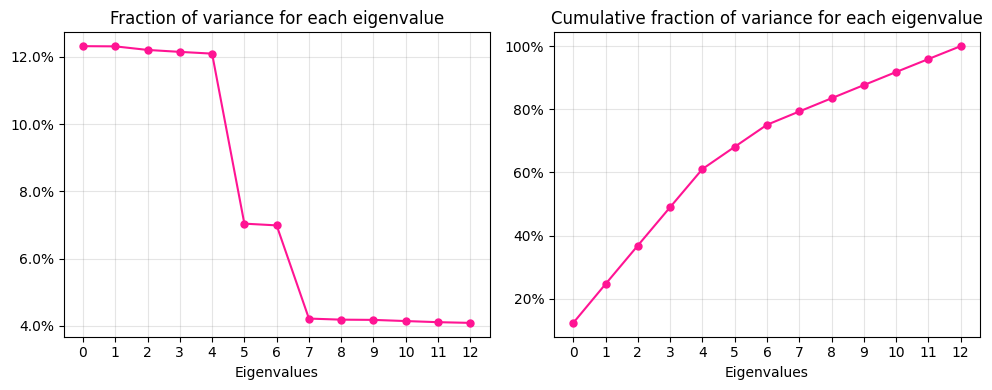

In [43]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
xgrid = np.arange(13)

ax[0].plot(xgrid, evals, marker = 'o', markersize = 5, ls = '-', color = 'deeppink')
ax[0].grid(c='grey', alpha = 0.2)
ax[0].set_xlabel('Eigenvalues')
ax[0].set_xticks(xgrid)
ax[0].yaxis.set_major_formatter(PercentFormatter(xmax=1))
ax[0].set_title('Fraction of variance for each eigenvalue')

ax[1].plot(xgrid, np.cumsum(evals), marker = 'o', markersize = 5, ls = '-', color = 'deeppink')
ax[1].grid(c='grey', alpha = 0.2)
ax[1].set_xlabel('Eigenvalues')
ax[1].set_xticks(xgrid)
ax[1].yaxis.set_major_formatter(PercentFormatter(xmax=1))
ax[1].set_title('Cumulative fraction of variance for each eigenvalue')

plt.tight_layout()
plt.show()

There's not a clear elbow in this scree plot, so I'm thinking all dimensions are needed for a good performance. Let's see how the scores change with a different number of dimensions from the PCA:

In [44]:
ndim = np.arange(1, 14)

accuracies_train_pca = np.empty(len(ndim))
contaminations_train_pca = np.empty(len(ndim))
completenesses_train_pca = np.empty(len(ndim))
tp_train_pca = np.empty(len(ndim))
fp_train_pca = np.empty(len(ndim))
fn_train_pca = np.empty(len(ndim))
tn_train_pca = np.empty(len(ndim))

accuracies_test_pca = np.empty(len(ndim))
contaminations_test_pca = np.empty(len(ndim))
completenesses_test_pca = np.empty(len(ndim))
tp_test_pca = np.empty(len(ndim))
fp_test_pca = np.empty(len(ndim))
fn_test_pca = np.empty(len(ndim))
tn_test_pca = np.empty(len(ndim))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=336)

for i, n in tqdm(enumerate(ndim), total=len(ndim)):

    pca = PCA(n_components=n, random_state = 336)

    # Dividing the fit_transform so that the test and train sets remain separated. So, I'm fitting the pca only on the train set, 
    # and then using it to transform both train and test set.
    X_train_tr = pca.fit_transform(scaled_X_train)
    X_test_tr = pca.transform(scaled_X_test)
        
    boost_pca = GradientBoostingClassifier(learning_rate = 0.50, max_depth = 4, random_state = 336)
    boost_pca.fit(X_train_tr, y_train)
    y_train_pred = boost_pca.predict(X_train_tr)
    y_test_pred = boost_pca.predict(X_test_tr)

    accuracies_train_pca[i] = accuracy_score(y_train, y_train_pred)
    contaminations_train_pca[i] = 1 - precision_score(y_train, y_train_pred, zero_division=0)
    completenesses_train_pca[i] = recall_score(y_train, y_train_pred)
    conf_matrix_train = confusion_matrix(y_train, y_train_pred)
    tn_train_pca[i], fp_train_pca[i], fn_train_pca[i], tp_train_pca[i] = conf_matrix_train.ravel()
    
    accuracies_test_pca[i] = accuracy_score(y_test, y_test_pred)
    contaminations_test_pca[i] = 1 - precision_score(y_test, y_test_pred, zero_division=0)
    completenesses_test_pca[i] = recall_score(y_test, y_test_pred)
    conf_matrix_test = confusion_matrix(y_test, y_test_pred)
    tn_test_pca[i], fp_test_pca[i], fn_test_pca[i], tp_test_pca[i] = conf_matrix_test.ravel()


  0%|          | 0/13 [00:00<?, ?it/s]

In [45]:
train_table_pca = pd.DataFrame({
    'PCA Dimensions': ndim,
    'Accuracy': accuracies_train_pca,
    'Contamination': contaminations_train_pca,
    'Completeness': completenesses_train_pca,
    'TP': tp_train_pca,
    'FP': fp_train_pca,
    'FN': fn_train_pca,
    'TN': tn_train_pca
})

train_table_pca[['Accuracy', 'Contamination', 'Completeness']] = train_table_pca[['Accuracy', 'Contamination', 'Completeness']].round(3)
train_table_pca[['TP', 'FP', 'FN', 'TN']] = train_table_pca[['TP', 'FP', 'FN', 'TN']].astype(int)

# Create DataFrame for test metrics
test_table_pca = pd.DataFrame({
    'PCA Dimensions': ndim,
    'Accuracy': accuracies_test_pca,
    'Contamination': contaminations_test_pca,
    'Completeness': completenesses_test_pca,
    'TP': tp_test_pca,
    'FP': fp_test_pca,
    'FN': fn_test_pca,
    'TN': tn_test_pca
})

test_table_pca[['Accuracy', 'Contamination', 'Completeness']] = test_table_pca[['Accuracy', 'Contamination', 'Completeness']].round(3)
test_table_pca[['TP', 'FP', 'FN', 'TN']] = test_table_pca[['TP', 'FP', 'FN', 'TN']].astype(int)


In [46]:
display(Markdown("### Results of PCA before boosting on train dataset:"))
display(train_table_pca)

display(Markdown("### Results of PCA before boosting on test dataset:"))
display(test_table_pca)

### Results of PCA before boosting on train dataset:

,PCA Dimensions,Accuracy,Contamination,Completeness,TP,FP,FN,TN
0,1,0.866,0.078,0.070,700,59,9322,59919
1,2,0.867,0.084,0.079,792,73,9230,59905
2,3,0.874,0.169,0.153,1536,313,8486,59665
3,4,0.883,0.208,0.251,2511,658,7511,59320
4,5,0.964,0.116,0.858,8603,1124,1419,58854
5,6,0.973,0.083,0.892,8941,804,1081,59174
6,7,0.975,0.076,0.903,9045,741,977,59237
7,8,0.977,0.072,0.908,9095,702,927,59276
8,9,0.976,0.072,0.904,9057,703,965,59275
9,10,0.977,0.070,0.910,9118,689,904,59289


### Results of PCA before boosting on test dataset:

,PCA Dimensions,Accuracy,Contamination,Completeness,TP,FP,FN,TN
0,1,0.849,0.763,0.018,78,251,4282,25389
1,2,0.850,0.709,0.023,101,246,4259,25394
2,3,0.853,0.525,0.079,346,383,4014,25257
3,4,0.861,0.430,0.166,725,548,3635,25092
4,5,0.945,0.182,0.797,3475,775,885,24865
5,6,0.955,0.149,0.833,3632,635,728,25005
6,7,0.957,0.139,0.840,3662,591,698,25049
7,8,0.957,0.143,0.847,3692,618,668,25022
8,9,0.957,0.141,0.840,3662,599,698,25041
9,10,0.959,0.131,0.848,3697,556,663,25084


The results seem to get better as the number of dimensions increases, with the best results for ndim = 13. Let's cross-validate, as before, on the learning rate and the maximum depth, working with ndim = 13.

In [47]:
n_splits = 5

lr_range = np.array([0.01, 0.05, 0.1, 0.5])
depths_range = np.arange(3, 6, dtype = int)
# I'm considering only between 3 and 5 because, before, all the trees went to max_depth = 3, and because I'm afraid it
# would go in overfitting regime for max_depth > 5.

accuracy_cv_matrix = np.empty((len(lr_range), len(depths_range)))
precision_cv_matrix = np.empty((len(lr_range), len(depths_range)))
completeness_cv_matrix = np.empty((len(lr_range), len(depths_range)))

kf = KFold(n_splits=n_splits, shuffle=True, random_state=336)

pca = PCA(n_components=13, random_state = 336)

X_train_tr = pca.fit_transform(scaled_X_train)
X_test_tr = pca.transform(scaled_X_test)

for i, l_rate in tqdm(enumerate(lr_range), total = len(lr_range)):

    for j, depth in tqdm(enumerate(depths_range), total = len(depths_range)):
    
        boost = GradientBoostingClassifier(learning_rate = l_rate, max_depth = depth, random_state = 336)
        
        accuracy = []
        precision = []
        completeness = []
        
        for train_index, test_index in kf.split(X_train_tr):
            X_train_cv, X_test_cv = X_train_tr[train_index], X_train_tr[test_index]
            y_train_cv, y_test_cv = y_train[train_index], y_train[test_index]
            
            boost.fit(X_train_cv, y_train_cv)
            y_pred_test_cv = boost.predict(X_test_cv)
            
            accuracy.append(accuracy_score(y_test_cv, y_pred_test_cv))
            precision.append(precision_score(y_test_cv, y_pred_test_cv, zero_division=0))
            completeness.append(recall_score(y_test_cv, y_pred_test_cv))
    
        accuracy_cv_matrix[i, j] = np.mean(accuracy)
        precision_cv_matrix[i, j] = np.mean(precision)
        completeness_cv_matrix[i, j] = np.mean(completeness)


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

In [48]:
accuracy_cv_matrix

array([[0.86418571, 0.88181429, 0.89838571],
       [0.93581429, 0.94705714, 0.95264286],
       [0.94951429, 0.95541429, 0.95861429],
       [0.95844286, 0.96094286, 0.96051429]])

In [49]:
precision_cv_matrix

array([[0.93915667, 0.90446143, 0.92690887],
       [0.85367132, 0.86412556, 0.86471249],
       [0.86457609, 0.87054261, 0.87497323],
       [0.86671455, 0.8762858 , 0.87085075]])

In [50]:
completeness_cv_matrix

array([[0.05492528, 0.19522153, 0.31511861],
       [0.66594916, 0.74787234, 0.79353886],
       [0.76768931, 0.80899883, 0.82959246],
       [0.83885467, 0.84689423, 0.85041504]])

In [51]:
print('Learning rates considered:')
print(lr_range)

print('depths considered:')
print(depths_range)

cv_matrices = [accuracy_cv_matrix, precision_cv_matrix, completeness_cv_matrix]

best_lr_pca_cv = np.empty(3)
best_depth_pca_cv = np.empty(3)

for i in range(3):

    best_index_flat = np.argmax(cv_matrices[i]) 
    best_index_2d = np.unravel_index(best_index_flat, cv_matrices[i].shape)
    
    best_lr_pca_cv[i] = lr_range[best_index_2d[0]]
    best_depth_pca_cv[i] = depths_range[best_index_2d[1]]
    
    print('\nScoring metric: ' + str(scoring_metrics[i]))
    print(' Best learning rate: %.2f' % best_lr_pca_cv[i]) 
    print(' Best max_depth: %i' % best_depth_pca_cv[i]) 


Learning rates considered:
[0.01 0.05 0.1  0.5 ]
depths considered:
[3 4 5]

Scoring metric: Accuracy
 Best learning rate: 0.50
 Best max_depth: 4

Scoring metric: Contamination
 Best learning rate: 0.01
 Best max_depth: 3

Scoring metric: Completeness
 Best learning rate: 0.50
 Best max_depth: 5


In [52]:
accuracies_train_pca_cv = np.empty(3)
contaminations_train_pca_cv = np.empty(3)
completenesses_train_pca_cv = np.empty(3)
tp_train_pca_cv = np.empty(3)
fp_train_pca_cv = np.empty(3)
fn_train_pca_cv = np.empty(3)
tn_train_pca_cv = np.empty(3)

accuracies_test_pca_cv = np.empty(3)
contaminations_test_pca_cv = np.empty(3)
completenesses_test_pca_cv = np.empty(3)
tp_test_pca_cv = np.empty(3)
fp_test_pca_cv = np.empty(3)
fn_test_pca_cv = np.empty(3)
tn_test_pca_cv = np.empty(3)

y_prob_pca_cv = []

for (i, l_rate), depth in tqdm(zip(enumerate(best_lr_pca_cv), best_depth_pca_cv), total=len(best_lr_pca_cv)):

    boost_pca_cv = GradientBoostingClassifier(learning_rate = l_rate, max_depth = int(depth), random_state = 336)
    boost_pca_cv.fit(X_train_tr, y_train)
    y_train_pred = boost_pca_cv.predict(X_train_tr)
    y_test_pred = boost_pca_cv.predict(X_test_tr)
    y_prob = boost_pca_cv.predict_proba(X_test_tr)

    accuracies_train_pca_cv[i] = accuracy_score(y_train, y_train_pred)
    contaminations_train_pca_cv[i] = 1 - precision_score(y_train, y_train_pred)
    completenesses_train_pca_cv[i] = recall_score(y_train, y_train_pred)
    conf_matrix_train = confusion_matrix(y_train, y_train_pred)
    tn_train_pca_cv[i], fp_train_pca_cv[i], fn_train_pca_cv[i], tp_train_pca_cv[i] = conf_matrix_train.ravel()
    
    accuracies_test_pca_cv[i] = accuracy_score(y_test, y_test_pred)
    contaminations_test_pca_cv[i] = 1 - precision_score(y_test, y_test_pred)
    completenesses_test_pca_cv[i] = recall_score(y_test, y_test_pred)
    conf_matrix_test = confusion_matrix(y_test, y_test_pred)
    tn_test_pca_cv[i], fp_test_pca_cv[i], fn_test_pca_cv[i], tp_test_pca_cv[i] = conf_matrix_test.ravel()

    y_prob_pca_cv.append(y_prob)


  0%|          | 0/3 [00:00<?, ?it/s]

In [53]:
train_table_pca_cv = pd.DataFrame({
    'Scoring metric for CV': scoring_metrics,
    'Learning_rate': best_lr_pca_cv,
    'Max_depth': best_depth_pca_cv,
    'Accuracy': accuracies_train_pca_cv,
    'Contamination': contaminations_train_pca_cv,
    'Completeness': completenesses_train_pca_cv,
    'True positives': tp_train_pca_cv,
    'False positives': fp_train_pca_cv,
    'False negatives': fn_train_pca_cv,
    'True negatives': tn_train_pca_cv
})

train_table_pca_cv[['Learning_rate', 'Accuracy', 'Contamination', 'Completeness']] = train_table_pca_cv[['Learning_rate', 'Accuracy', 'Contamination', 'Completeness']].round(3)
train_table_pca_cv[['Max_depth', 'True positives', 'False positives', 'False negatives', 'True negatives']] = train_table_pca_cv[['Max_depth', 'True positives', 'False positives', 'False negatives', 'True negatives']].astype(int)




test_table_pca_cv = pd.DataFrame({
    'Scoring metric for CV': scoring_metrics,
    'Learning_rate': best_lr_pca_cv,
    'Max_depth': best_depth_pca_cv,
    'Accuracy': accuracies_test_pca_cv,
    'Contamination': contaminations_test_pca_cv,
    'Completeness': completenesses_test_pca_cv,
    'True positives': tp_test_pca_cv,
    'False positives': fp_test_pca_cv,
    'False negatives': fn_test_pca_cv,
    'True negatives': tn_test_pca_cv
    })

test_table_pca_cv[['Learning_rate', 'Accuracy', 'Contamination', 'Completeness']] = test_table_pca_cv[['Learning_rate', 'Accuracy', 'Contamination', 'Completeness']].round(3)
test_table_pca_cv[['Max_depth', 'True positives', 'False positives', 'False negatives', 'True negatives']] = test_table_pca_cv[['Max_depth', 'True positives', 'False positives', 'False negatives', 'True negatives']].astype(int)


In [54]:
display(Markdown("### Results of PCA boosting classification (cross-validated on learning_rate and max_depth) on train dataset:"))
display(train_table_pca_cv)

display(Markdown("### Results of PCA boosting classification (cross-validated on learning_rate and max_depth) on test dataset:"))
display(test_table_pca_cv)

### Results of PCA boosting classification (cross-validated on learning_rate and max_depth) on train dataset:

,Scoring metric for CV,Learning_rate,Max_depth,Accuracy,Contamination,Completeness,True positives,False positives,False negatives,True negatives
0,Accuracy,0.50,4,0.980,0.063,0.919,9208,614,814,59364
1,Contamination,0.01,3,0.866,0.070,0.066,664,50,9358,59928
2,Completeness,0.50,5,0.989,0.032,0.958,9599,315,423,59663


### Results of PCA boosting classification (cross-validated on learning_rate and max_depth) on test dataset:

,Scoring metric for CV,Learning_rate,Max_depth,Accuracy,Contamination,Completeness,True positives,False positives,False negatives,True negatives
0,Accuracy,0.50,4,0.960,0.128,0.850,3706,545,654,25095
1,Contamination,0.01,3,0.864,0.061,0.067,294,19,4066,25621
2,Completeness,0.50,5,0.961,0.124,0.852,3715,525,645,25115


The results are very good, but slighty worse than the ones obtained without PCA.


## Summary of results - best classifier

The best classifier is confirmed to be the boosting one, without PCA: for max_depth = $4$ and learning_rate = $0.5$, it reached an accuracy of $\sim97.4\%$.

In [56]:
display(test_table_boo)

,Scoring metric for CV,Learning_rate,Max_depth,Accuracy,Contamination,Completeness,True positives,False positives,False negatives,True negatives
0,Accuracy,0.50,4,0.974,0.082,0.901,3930,351,430,25289
1,Contamination,0.01,5,0.950,0.071,0.713,3108,236,1252,25404
2,Completeness,0.50,4,0.974,0.082,0.901,3930,351,430,25289
